https://allensdk.readthedocs.io/en/latest/_static/examples/nb/mouse_connectivity.html

In [1]:
import os, sys, time, glob,json
import tifffile as tif
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import csv
import warnings
warnings.filterwarnings('ignore')

from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from allensdk.api.queries.ontologies_api import OntologiesApi
from scipy.ndimage.interpolation import zoom


In [2]:
# location of your repo clone
sys.path.append("../../..")

In [3]:
# base path
src = "/home/emilyjanedennis/Desktop/"

## 2021.08.03

In [4]:
mcc = MouseConnectivityCache(manifest_file='connectivity/mouse_connectivity_manifest.json')
all_experiments = mcc.get_experiments(dataframe=True)
print("%d total experiments" % len(all_experiments))


2992 total experiments


In [5]:
all_experiments.loc[122642490]

gender                                            M
injection_structures                     [985, 993]
injection_volume                           0.151071
injection_x                                    4300
injection_y                                    2690
injection_z                                    7050
product_id                                        5
specimen_name                          Syt6-Cre-585
strain                                     C57BL/6J
structure_abbrev                                MOs
structure_id                                    993
structure_name                 Secondary motor area
transgenic_line                      Syt6-Cre_KI148
transgenic_line_id                      1.77839e+08
id                                        122642490
primary_injection_structure                     985
Name: 122642490, dtype: object

In [6]:
# grab the StructureTree instance
structure_tree = mcc.get_structure_tree()

# get info on some structures
structures = structure_tree.get_structures_by_name(['Primary visual area', 'Hypothalamus'])
pd.DataFrame(structures)

oapi = OntologiesApi()

# get the ids of all the structure sets in the tree
structure_set_ids = structure_tree.get_structure_sets()

# query the API for information on those structure sets
pd.DataFrame(oapi.get_structure_sets(structure_set_ids))

,description,id,name
0,List of structures in Isocortex layer 5,667481446,Isocortex layer 5
1,List of structures in Isocortex layer 6b,667481450,Isocortex layer 6b
2,Summary structures of the cerebellum,688152368,Cerebellum
3,List of structures for ABA Differential Search,12,ABA - Differential Search
4,List of valid structures for projection target...,184527634,Mouse Connectivity - Target Search
5,Structures whose surfaces are represented by a...,691663206,Mouse Brain - Has Surface Mesh
6,Summary structures of the midbrain,688152365,Midbrain
7,Summary structures of the medulla,688152367,Medulla
8,Summary structures of the striatum,688152361,Striatum
9,Structures representing subdivisions of the mo...,687527945,Mouse Connectivity - Summary


In [7]:
#from the above table, we want regions valid for target search
summary_structures=pd.DataFrame(structure_tree.get_structures_by_set_id([184527634])) #set id == fo target search
summary_structures

,acronym,graph_id,graph_order,id,name,structure_id_path,structure_set_ids,rgb_triplet
0,grey,1,1,8,Basic cell groups and regions,"[997, 8]","[112905828, 691663206, 12, 184527634, 11290581...","[191, 218, 227]"
1,CH,1,2,567,Cerebrum,"[997, 8, 567]","[112905828, 691663206, 12, 184527634, 11290581...","[176, 240, 255]"
2,CTX,1,3,688,Cerebral cortex,"[997, 8, 567, 688]","[112905828, 691663206, 12, 184527634, 11290581...","[176, 255, 184]"
3,CTXpl,1,4,695,Cortical plate,"[997, 8, 567, 688, 695]","[112905828, 691663206, 12, 184527634, 11290581...","[112, 255, 112]"
4,Isocortex,1,5,315,Isocortex,"[997, 8, 567, 688, 695, 315]","[2, 112905828, 691663206, 12, 184527634, 11290...","[112, 255, 113]"
...,...,...,...,...,...,...,...,...
835,sm,1,1285,802,stria medullaris,"[997, 1009, 991, 824, 1083, 802]","[184527634, 691663206]","[204, 204, 204]"
836,fr,1,1286,595,fasciculus retroflexus,"[997, 1009, 991, 824, 1083, 595]","[184527634, 691663206]","[204, 204, 204]"
837,hbc,1,1287,611,habenular commissure,"[997, 1009, 991, 824, 1083, 611]","[184527634, 691663206]","[204, 204, 204]"
838,SEZ,1,1295,98,subependymal zone,"[997, 73, 81, 98]","[10, 184527634, 691663206]","[170, 170, 170]"


In [8]:
# find wild-type injections
allen_experiments = mcc.get_experiments(dataframe=True, cre=False, 
                                       injection_structure_ids=summary_structures['id'].tolist())
blk_six = allen_experiments[allen_experiments['strain']=='C57BL/6J']

print("%d allen experiments" % len(allen_experiments))
print("%d blk_six experiments" % len(blk_six))

structure_unionizes = mcc.get_structure_unionizes([ int(e) for e in blk_six['id'] ], 
                                                  is_injection=False,
                                                  structure_ids=summary_structures['id'].tolist(),
                                                  include_descendants=True)

print("%d wt non-injection, structure unionizes" % len(structure_unionizes))


498 allen experiments
498 blk_six experiments
1242520 wt non-injection, structure unionizes


In [9]:
experiment_ids = [ e for e in blk_six['id'].to_list() ]
ctx_children = structure_tree.descendant_ids( summary_structures['id'] )
ctx_children

[[8,
  567,
  688,
  695,
  315,
  184,
  68,
  667,
  526157192,
  526157196,
  526322264,
  500,
  107,
  219,
  299,
  644,
  947,
  985,
  320,
  943,
  648,
  844,
  882,
  993,
  656,
  962,
  767,
  1021,
  1085,
  453,
  12993,
  12994,
  12995,
  12996,
  12997,
  12998,
  322,
  793,
  346,
  865,
  921,
  686,
  719,
  353,
  558,
  838,
  654,
  702,
  889,
  929,
  329,
  981,
  201,
  1047,
  1070,
  1038,
  1062,
  480149202,
  480149206,
  480149210,
  480149214,
  480149218,
  480149222,
  480149226,
  337,
  1030,
  113,
  1094,
  1128,
  478,
  510,
  345,
  878,
  657,
  950,
  974,
  1102,
  2,
  369,
  450,
  854,
  577,
  625,
  945,
  1026,
  361,
  1006,
  670,
  1086,
  1111,
  9,
  461,
  182305689,
  182305693,
  182305697,
  182305701,
  182305705,
  182305709,
  182305713,
  378,
  873,
  806,
  1035,
  1090,
  862,
  893,
  1057,
  36,
  180,
  148,
  187,
  638,
  662,
  677,
  897,
  1106,
  1010,
  1058,
  857,
  849,
  247,
  1011,
  527,
  600,
  678

In [10]:
pm = mcc.get_projection_matrix(experiment_ids = experiment_ids, 
                               projection_structure_ids = ctx_children[0],
                               parameter = 'projection_density')


In [11]:
pm

{'matrix': array([[2.51223076e-04, 5.03079977e-05, 3.75939412e-05, ...,
         8.25743312e-08, 0.00000000e+00, 3.65863833e-06],
        [1.08175158e-02, 1.78899466e-03, 1.40811243e-04, ...,
         1.37793014e-02, 1.26772956e-03, 5.22979076e-03],
        [1.14687160e-03, 1.83925188e-03, 7.41279850e-04, ...,
         0.00000000e+00, 0.00000000e+00, 7.58210084e-05],
        ...,
        [9.04803667e-03, 1.39383824e-02, 1.15610421e-02, ...,
         4.77762008e-06, 0.00000000e+00, 6.09413344e-05],
        [4.22760827e-04, 2.16041939e-05, 2.36921514e-05, ...,
         0.00000000e+00, 7.18065209e-08, 0.00000000e+00],
        [3.52089090e-03, 4.89675072e-03, 5.21456241e-03, ...,
         2.44755990e-04, 6.52329689e-05, 3.63101809e-03]]),
 'rows': [272824561,
  113400134,
  117317884,
  180073473,
  127710392,
  307297141,
  180917660,
  174360333,
  100140949,
  156978574,
  147790181,
  100141454,
  126523791,
  146046430,
  272916202,
  175106053,
  147162027,
  126352037,
  131068390,


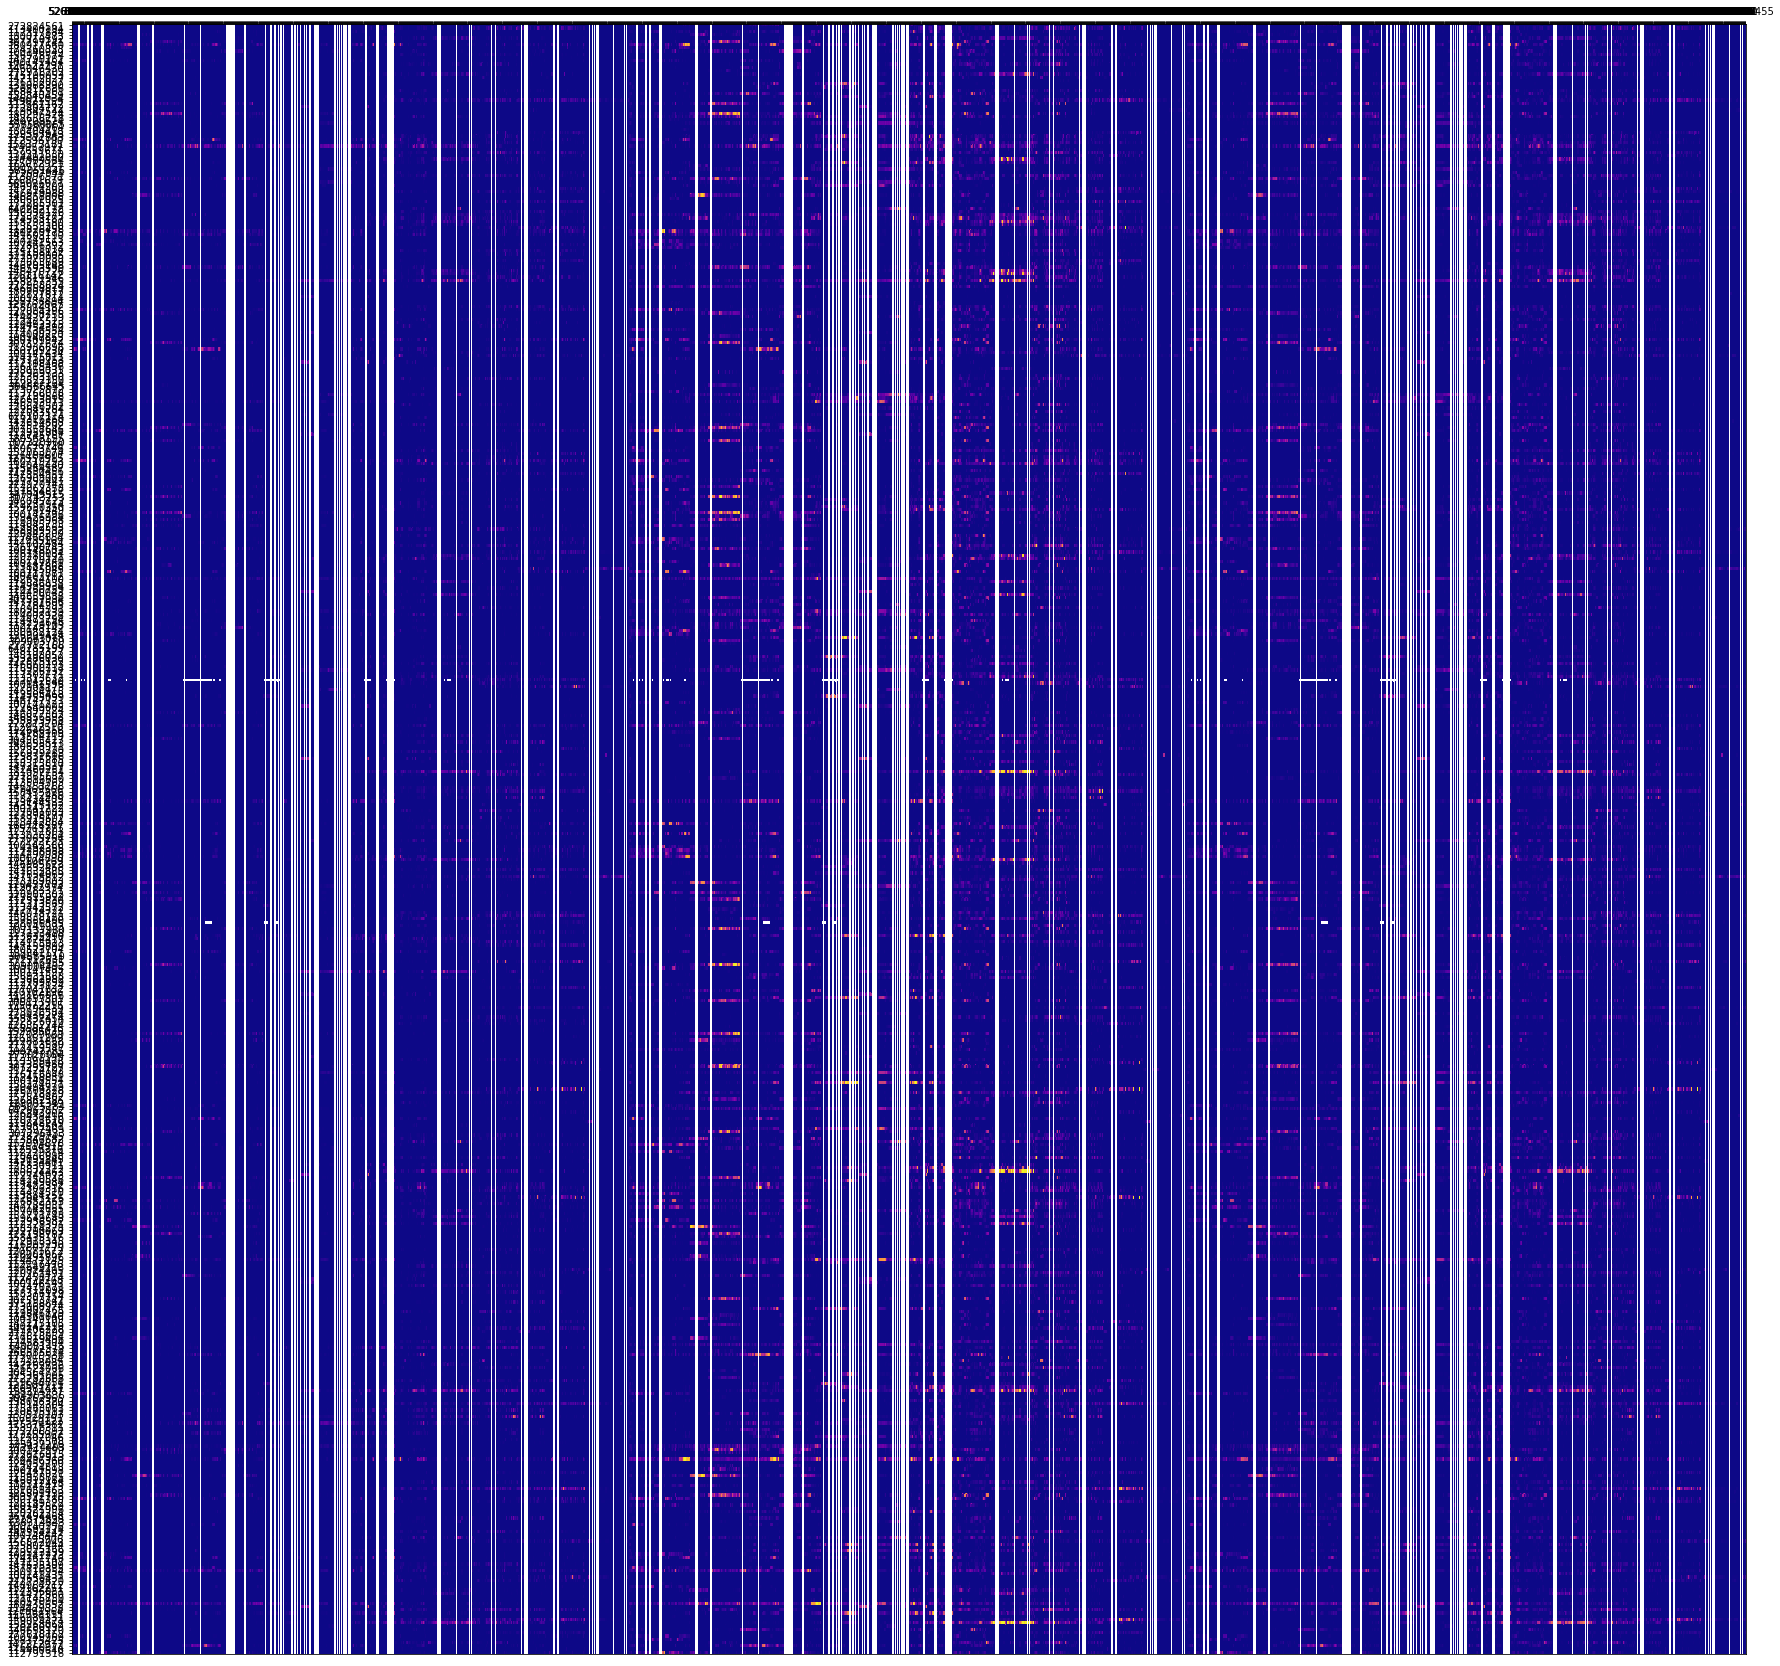

In [99]:
row_labels = pm['rows'] # these are just experiment ids
column_labels = [ c['structure_id'] for c in pm['columns'] ] 
matrix = pm['matrix']

fig, ax = plt.subplots(figsize=(30,30))
heatmap = ax.pcolor(matrix, cmap=plt.cm.plasma)

# put the major ticks at the middle of each cell
ax.set_xticks(np.arange(matrix.shape[1])+0.5, minor=False)
ax.set_yticks(np.arange(matrix.shape[0])+0.5, minor=False)

ax.set_xlim([0, matrix.shape[1]])
ax.set_ylim([0, matrix.shape[0]])          

# want a more natural, table-like display
ax.invert_yaxis()
ax.xaxis.tick_top()

ax.set_xticklabels(column_labels, minor=False)
ax.set_yticklabels(row_labels, minor=False)
plt.show()

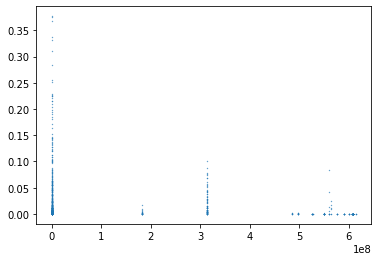

In [13]:
row = 401
exp_name = pm['rows'][row]
values=pm['matrix'][row]
struct_ids = pm['columns']
ids=[struct['structure_id'] for struct in struct_ids]
plt.scatter(ids,values,s=.1)

In [17]:
# translate structure ids to PRA ids
ids

[8,
 567,
 688,
 695,
 315,
 184,
 68,
 667,
 526157192,
 526157196,
 526322264,
 500,
 107,
 219,
 299,
 644,
 947,
 985,
 320,
 943,
 648,
 844,
 882,
 993,
 656,
 962,
 767,
 1021,
 1085,
 453,
 12993,
 12994,
 12995,
 12996,
 12997,
 12998,
 322,
 793,
 346,
 865,
 921,
 686,
 719,
 353,
 558,
 838,
 654,
 702,
 889,
 929,
 329,
 981,
 201,
 1047,
 1070,
 1038,
 1062,
 480149202,
 480149206,
 480149210,
 480149214,
 480149218,
 480149222,
 480149226,
 337,
 1030,
 113,
 1094,
 1128,
 478,
 510,
 345,
 878,
 657,
 950,
 974,
 1102,
 2,
 369,
 450,
 854,
 577,
 625,
 945,
 1026,
 361,
 1006,
 670,
 1086,
 1111,
 9,
 461,
 182305689,
 182305693,
 182305697,
 182305701,
 182305705,
 182305709,
 182305713,
 378,
 873,
 806,
 1035,
 1090,
 862,
 893,
 1057,
 36,
 180,
 148,
 187,
 638,
 662,
 677,
 897,
 1106,
 1010,
 1058,
 857,
 849,
 247,
 1011,
 527,
 600,
 678,
 252,
 156,
 243,
 480149230,
 480149234,
 480149238,
 480149242,
 480149246,
 480149250,
 480149254,
 1002,
 735,
 251,
 8

In [11]:
# get PMA file, check for IDs there
# if any are missing, fill them in manually using below search

In [15]:
pma = pd.read_csv('/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/labels/PMA_in_PRA.csv')

In [64]:
chk=[]
for i in ids:
    if i not in pma.ID.tolist():
        chk.append(i)

In [65]:
np.unique(chk)

array([], dtype=float64)

In [66]:
for i in summary_structures.acronym.tolist():
    if i in np.unique(chk):
        print(summary_structures[summary_structures.acronym==i])

In [67]:
for i in np.unique(chk):
    print(i)
    print(summary_structures[summary_structures.id==i]['name'])
    print(summary_structures[summary_structures.id==i]['acronym'])

In [ ]:
# ok great, now we have all our IDs are in PMA
# this means we have them in PRA as well
# let's plot by PRA values

In [16]:
pras=[]
prastruct=[]
for i in ids:
    if i in pma.ID.tolist():
        pras.append(pma[pma.ID==i]['praid'].tolist()[0])
        prastruct.append(pma[pma.ID==i]['structure_id_path'].tolist()[0])
    else:
        pras.append(-100)
        prastruct.append('-100')
        print(i)

In [75]:
prastruct

['/0/1',
 '/0/37',
 '/0/37/59',
 '/0/37/59',
 '/0/37/59',
 '/0/37/59/93',
 '/0/37/59/93',
 '/0/37/59/93',
 '/0/37/59/93',
 '/0/37/59/93',
 '/0/37/59/93',
 '/0/37/59/238',
 '/0/37/59/238',
 '/0/37/59/238',
 '/0/37/59/238',
 '/0/37/59/238',
 '/0/37/59/238',
 '/0/37/59/238/463',
 '/0/37/59/238/463',
 '/0/37/59/238/463',
 '/0/37/59/238/463',
 '/0/37/59/238/463',
 '/0/37/59/238/463',
 '/0/37/59/238/464',
 '/0/37/59/238/464',
 '/0/37/59/238/464',
 '/0/37/59/238/464',
 '/0/37/59/238/464',
 '/0/37/59/238/464',
 '/0/37/59/242',
 '/0/37/59/242',
 '/0/37/59/242',
 '/0/37/59/242',
 '/0/37/59/242',
 '/0/37/59/242',
 '/0/37/59/242',
 '/0/37/59/242/96',
 '/0/37/59/242/96',
 '/0/37/59/242/96',
 '/0/37/59/242/96',
 '/0/37/59/242/96',
 '/0/37/59/242/96',
 '/0/37/59/242/96',
 '/0/37/59/242/96',
 '/0/37/59/242/96',
 '/0/37/59/242/96',
 '/0/37/59/242/96',
 '/0/37/59/242/96',
 '/0/37/59/242/96',
 '/0/37/59/242/96',
 '/0/37/59/242/96',
 '/0/37/59/242/96',
 '/0/37/59/242/96',
 '/0/37/59/242/96',
 '/0/37/59/24

In [17]:
row_labels = pm['rows'] # these are just experiment ids
matrix = pm['matrix']
np.shape(matrix)

(498, 3300)

In [18]:
column_labels = [ c['structure_id'] for c in pm['columns'] ] 
np.shape(column_labels)
    
pras=[]
prastruct=[]
for i in column_labels:
    if i in pma.ID.tolist():
        pras.append(pma[pma.ID==i]['praid'].tolist()[0])
        prastruct.append(pma[pma.ID==i]['structure_id_path'].tolist()[0])
    else:
        pras.append(-100)
        prastruct.append('-100')
        print(i)

In [19]:
np.shape(prastruct)

(3300,)

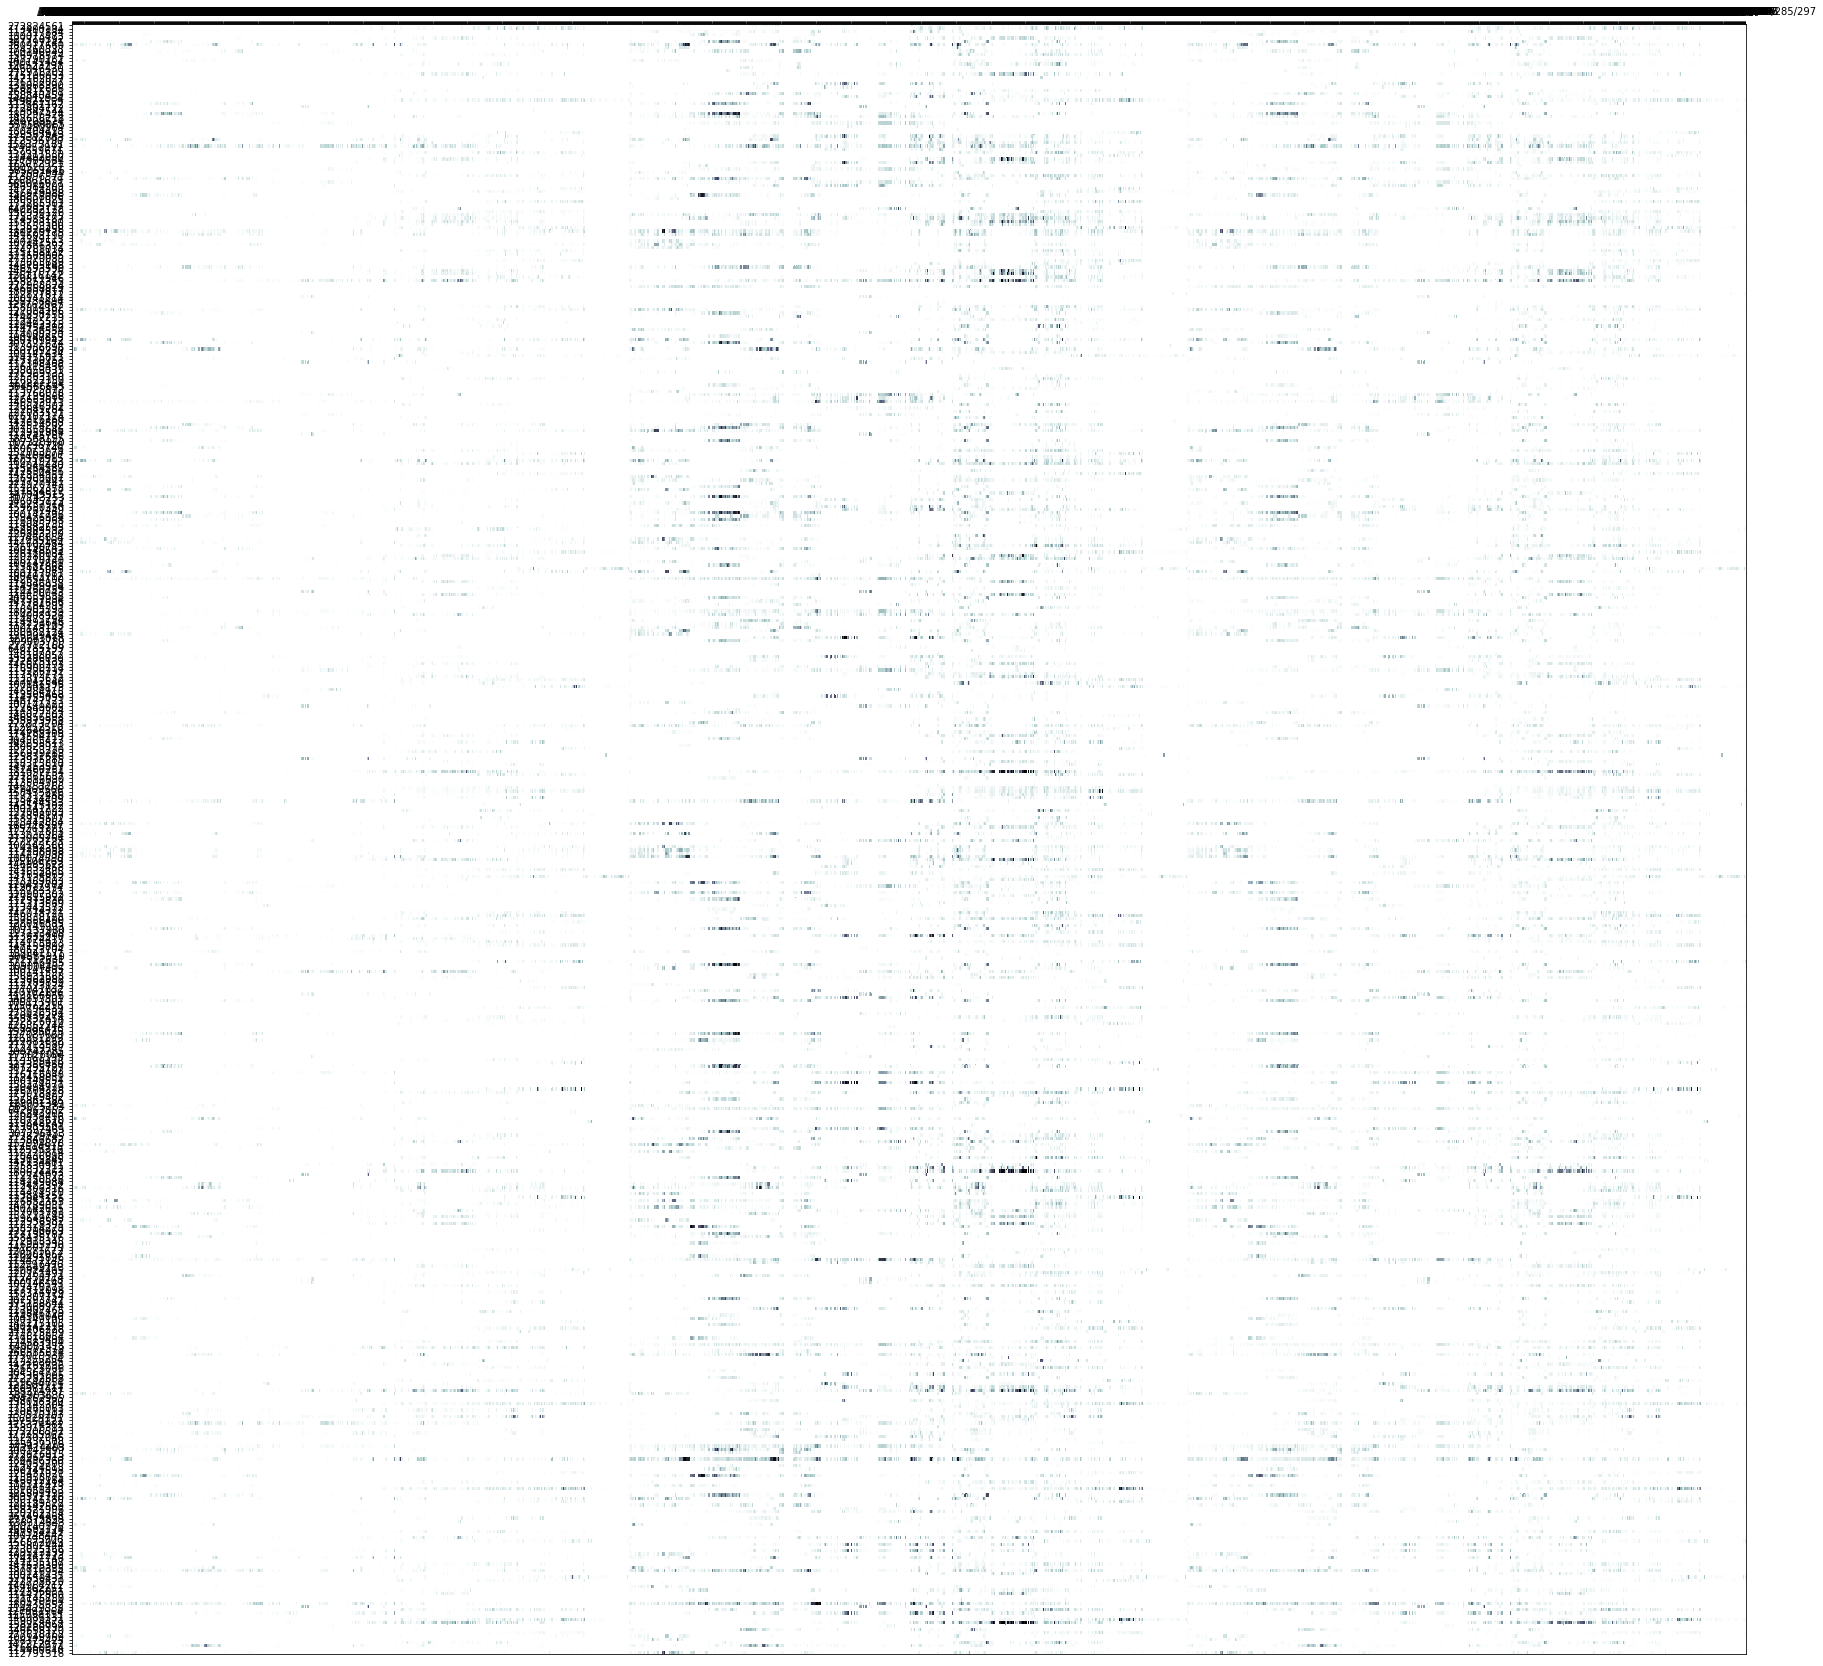

In [20]:
fig, ax = plt.subplots(figsize=(30,30))
heatmap = ax.pcolor(matrix, cmap=plt.cm.bone_r)

# put the major ticks at the middle of each cell
ax.set_xticks(np.arange(matrix.shape[1])+0.5, minor=False)
ax.set_yticks(np.arange(matrix.shape[0])+0.5, minor=False)

ax.set_xlim([0, matrix.shape[1]])
ax.set_ylim([0, matrix.shape[0]])          

# want a more natural, table-like display
ax.invert_yaxis()
ax.xaxis.tick_top()

ax.set_xticklabels(prastruct, minor=False)
ax.set_yticklabels(row_labels, minor=False)
plt.show()

In [21]:
import scipy.cluster as scc

In [22]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [23]:
test=matrix.copy()

In [24]:
test=(np.nan_to_num(matrix))

In [25]:
linked=linkage(test,'single')

In [26]:
linked

array([[8.40000000e+01, 4.44000000e+02, 1.56607720e-02, 2.00000000e+00],
       [2.27000000e+02, 4.98000000e+02, 1.70400539e-02, 3.00000000e+00],
       [1.26000000e+02, 1.55000000e+02, 1.72751339e-02, 2.00000000e+00],
       ...,
       [4.38000000e+02, 9.90000000e+02, 4.21773047e+00, 4.95000000e+02],
       [9.91000000e+02, 9.92000000e+02, 4.45362688e+00, 4.97000000e+02],
       [4.82000000e+02, 9.93000000e+02, 4.94822192e+00, 4.98000000e+02]])

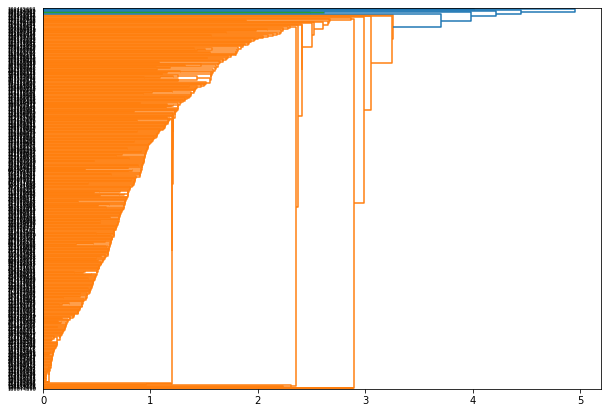

In [27]:
plt.figure(figsize=(10,7))
dendrogram(linked,
          orientation='right',
          labels=row_labels,
          distance_sort='descending')
plt.show()

https://stackabuse.com/hierarchical-clustering-with-python-and-scikit-learn

In [28]:
from sklearn.cluster import AgglomerativeClustering

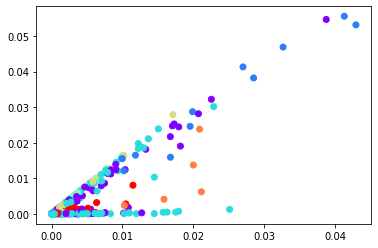

In [53]:
cluster = AgglomerativeClustering(n_clusters=7, affinity='euclidean', linkage='ward')
xx=cluster.fit_predict(test)
plt.scatter(test[:,0],test[:,1], c=cluster.labels_, cmap='rainbow')

In [56]:
np.shape(test)

(498, 3300)

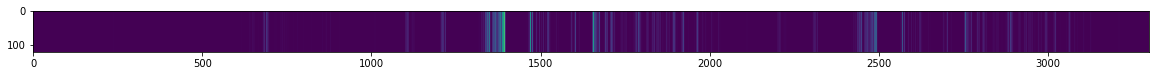

In [64]:
plt.figure(figsize=(20,7))
plt.imshow(test[xx[xx==0],:])
plt.show()

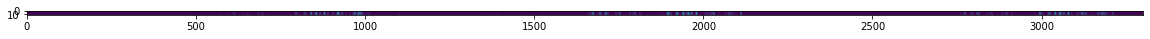

In [66]:
plt.figure(figsize=(20,7))
plt.imshow(test[xx[xx==1],:])
plt.show()

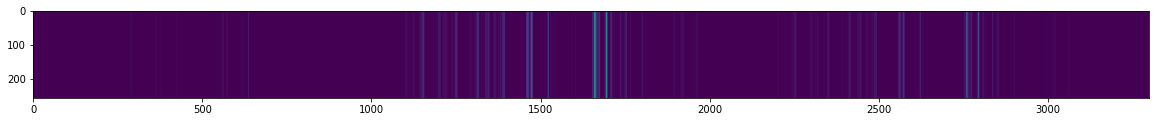

In [67]:
plt.figure(figsize=(20,7))
plt.imshow(test[xx[xx==2],:])
plt.show()

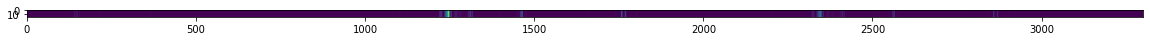

In [70]:
plt.figure(figsize=(20,7))
plt.imshow(test[xx[xx==3],:])
plt.show()

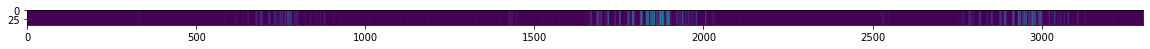

In [71]:
plt.figure(figsize=(20,7))
plt.imshow(test[xx[xx==4],:])
plt.show()

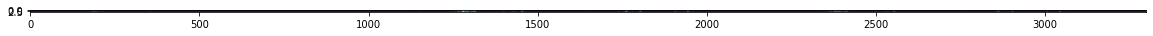

In [72]:
plt.figure(figsize=(20,7))
plt.imshow(test[xx[xx==5],:])
plt.show()

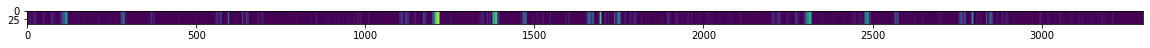

In [73]:
plt.figure(figsize=(20,7))
plt.imshow(test[xx[xx==6],:])
plt.show()

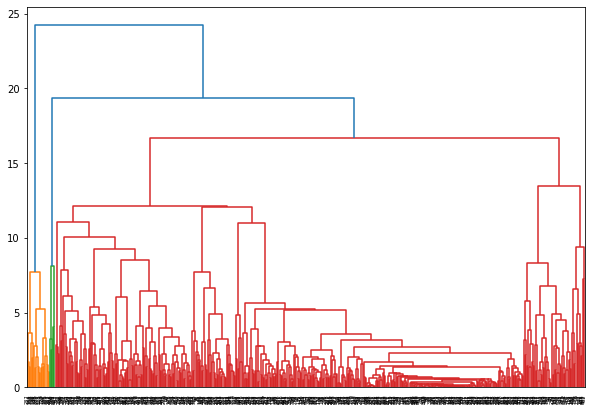

In [42]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10,7))
dend=shc.dendrogram(shc.linkage(test,method='ward'))

In [45]:
dend.keys()

dict_keys(['icoord', 'dcoord', 'ivl', 'leaves', 'color_list', 'leaves_color_list'])

In [49]:
dend['leaves']

[287,
 144,
 318,
 308,
 27,
 149,
 24,
 298,
 389,
 276,
 123,
 449,
 5,
 127,
 97,
 338,
 165,
 369,
 267,
 352,
 488,
 228,
 350,
 78,
 417,
 443,
 367,
 52,
 262,
 406,
 99,
 355,
 37,
 472,
 354,
 64,
 214,
 427,
 58,
 273,
 139,
 363,
 495,
 21,
 182,
 490,
 8,
 184,
 89,
 452,
 74,
 150,
 424,
 122,
 382,
 63,
 359,
 124,
 265,
 361,
 80,
 67,
 153,
 446,
 251,
 157,
 497,
 357,
 66,
 467,
 164,
 288,
 252,
 342,
 244,
 87,
 186,
 344,
 435,
 47,
 160,
 141,
 95,
 394,
 110,
 397,
 413,
 218,
 441,
 210,
 328,
 175,
 188,
 88,
 151,
 310,
 478,
 3,
 213,
 395,
 401,
 372,
 376,
 59,
 340,
 201,
 178,
 408,
 494,
 12,
 242,
 360,
 240,
 393,
 92,
 116,
 329,
 326,
 159,
 346,
 484,
 356,
 271,
 9,
 69,
 46,
 108,
 381,
 410,
 1,
 39,
 229,
 222,
 303,
 460,
 130,
 77,
 402,
 134,
 36,
 198,
 445,
 275,
 86,
 280,
 233,
 470,
 255,
 174,
 366,
 60,
 76,
 75,
 41,
 162,
 180,
 362,
 462,
 56,
 249,
 341,
 425,
 234,
 219,
 236,
 348,
 61,
 217,
 245,
 170,
 479,
 291,
 143,
 409,
 

In [92]:
from sklearn.metrics import pairwise_distances_argmin

In [93]:
def find_clusters(X,n_clusters,rseed=13):
    #randomly choose clusters
    rng = np.random.RandomState(rseed)
    i=rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

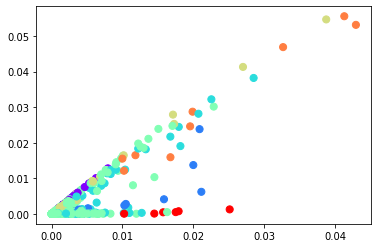

In [101]:
centers,labels=find_clusters(test,7,rseed=10)
plt.scatter(test[:,0],test[:,1],c=labels,s=50,cmap='rainbow')

In [105]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

In [106]:

tsne = TSNE(n_components=2, init='random', random_state=0)
digits_proj = tsne.fit_transform(test)

# Compute the clusters
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits_proj)


# Compute the accuracy

In [109]:
np.shape(clusters)


(498,)

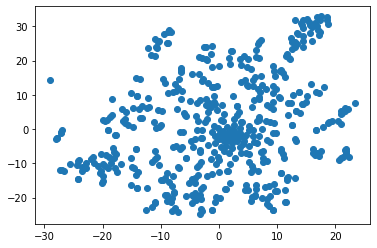

In [115]:
plt.scatter(digits_proj[:,0],digits_proj[:,1])

https://flothesof.github.io/k-means-numpy.html
https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html

https://scikit-learn.org/stable/modules/clustering.html#k-means

## 2020.11.27

In [2]:
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

(2000.0, 9000.0)

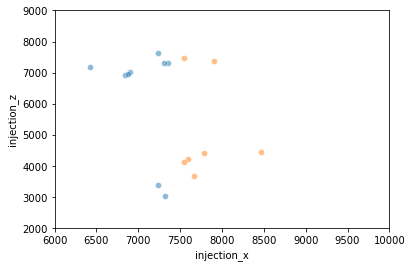

In [293]:
yfdf= males[ylist]

sns.scatterplot(yfdf.injection_x,yfdf.injection_z,alpha=0.5) #blue

gfdf = males[glist]


sns.scatterplot(gfdf.injection_x,gfdf.injection_z,alpha=0.5) #g
plt.xlim([6000,10000])
plt.ylim([2000,9000])

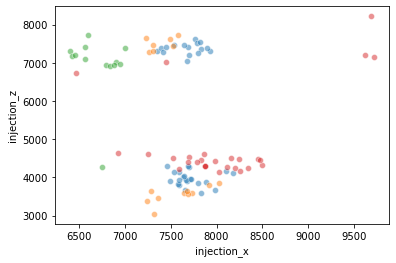

In [305]:
visam = all_experiments[all_experiments.structure_abbrev == 'VISam']
visal = all_experiments[all_experiments.structure_abbrev == 'VISal']
visa = all_experiments[all_experiments.structure_abbrev == 'VISa']
visrl = all_experiments[all_experiments.structure_abbrev == 'VISrl']
s1 = all_experiments[all_experiments.structure_abbrev=='SSp-tr']
rsc = all_experiments[all_experiments.structure_abbrev=='RSPagl']

sns.scatterplot(visam.injection_x,visam.injection_z,alpha=0.5) #blue
sns.scatterplot(visa.injection_x,visa.injection_z,alpha=0.5) #orange
sns.scatterplot(s1.injection_x,s1.injection_z,alpha=0.5) #greem
sns.scatterplot(rsc.injection_x,rsc.injection_z,alpha=0.5) #red


In [175]:
visam = males[males.structure_abbrev == 'VISam']
visal = males[males.structure_abbrev == 'VISal']
visa = males[males.structure_abbrev == 'VISa']
visrl = males[males.structure_abbrev == 'VISrl']
s1 = males[males.structure_abbrev=='SSp-tr']
rsc = males[males.structure_abbrev=='RSPagl']

,gender,injection_structures,injection_volume,injection_x,injection_y,injection_z,product_id,specimen_name,strain,structure_abbrev,structure_id,structure_name,transgenic_line,transgenic_line_id,id,primary_injection_structure
id,,,,,,,,,,,,,,,,
183617432,M,"[985, 993]",0.255162,3800,1710,7310,5,Htr2a-Cre-3437,None,MOs,993,Secondary motor area,Htr2a-Cre_KM207,177838942.0,183617432,985
524070052,M,"[985, 993]",0.018586,3990,2830,7110,5,Ctgf-2A-dgCre-242375,C57BL/6J,MOs,993,Secondary motor area,Ctgf-T2A-dgCre,309779993.0,524070052,985
168002073,M,[993],0.270741,3600,1650,7370,5,Cux2-IRES-Cre-93,None,MOs,993,Secondary motor area,Cux2-IRES-Cre,177839022.0,168002073,993
159372889,M,[993],0.001593,3580,2780,7250,5,Ntsr1-Cre-3562,C57BL/6J,MOs,993,Secondary motor area,Ntsr1-Cre_GN220,177837713.0,159372889,993
266645328,M,[993],0.166196,3370,2030,7490,5,Cux2-IRES-Cre-260,None,MOs,993,Secondary motor area,Cux2-IRES-Cre,177839022.0,266645328,993
288169842,M,[993],0.100080,3620,1910,7220,5,Tlx3-Cre_LURC-3598,None,MOs,993,Secondary motor area,Tlx3-Cre_PL56,265180449.0,288169842,993
180673746,M,"[184, 507, 723, 993]",0.139684,2090,3180,7380,5,378-1816,C57BL/6J,ORBl,723,"Orbital area, lateral part",None,NaN,180673746,184
292962283,M,"[342, 754]",0.023715,3810,6730,7050,5,Ntrk1-IRES-Cre_LURC-3547,None,OT,754,Olfactory tubercle,Ntrk1-IRES-Cre,183238310.0,292962283,342
141602484,M,"[985, 993]",0.209096,3970,1810,7400,5,378-1350,C57BL/6J,MOs,993,Secondary motor area,None,NaN,141602484,985


In [251]:
for i in males.structure_name:
    if 'stria' in i:
        print(i)

males[males.structure_name == 'Bed nuclei of the stria terminalis']

Bed nuclei of the stria terminalis
Bed nuclei of the stria terminalis
Bed nuclei of the stria terminalis
Bed nuclei of the stria terminalis
Bed nuclei of the stria terminalis
Area prostriata
Bed nuclei of the stria terminalis
Bed nuclei of the stria terminalis
Bed nuclei of the stria terminalis
Bed nuclei of the stria terminalis
Bed nuclei of the stria terminalis
Bed nuclei of the stria terminalis
Bed nuclei of the stria terminalis
Bed nuclei of the stria terminalis
Bed nuclei of the stria terminalis


,gender,injection_structures,injection_volume,injection_x,injection_y,injection_z,product_id,specimen_name,strain,structure_abbrev,structure_id,structure_name,transgenic_line,transgenic_line_id,id,primary_injection_structure
id,,,,,,,,,,,,,,,,
298835859,M,"[15, 127, 149, 181, 258, 262, 266, 310, 351, 4...",0.223965,5290,4810,5690,5,Drd3-Cre_KI196-128330,None,BST,351,Bed nuclei of the stria terminalis,Drd3-Cre_KI196,266649644.0,298835859,15
308386222,M,"[15, 351]",0.031178,5540,4870,6550,5,Rbp4-Cre_KL100-123745,None,BST,351,Bed nuclei of the stria terminalis,Rbp4-Cre_KL100,177838435.0,308386222,15
241280698,M,"[38, 351, 914]",0.004085,5540,5480,6080,5,Sim1-Cre-Homo-329,B6.FVB,BST,351,Bed nuclei of the stria terminalis,Sim1-Cre_KJ18,177837777.0,241280698,38
241279971,M,"[255, 262, 351, 672]",0.007666,5550,2950,7710,5,Sim1-Cre-Homo-328,B6.FVB,BST,351,Bed nuclei of the stria terminalis,Sim1-Cre_KJ18,177837777.0,241279971,255
159375036,M,"[15, 127, 262, 351, 1113]",0.023753,5560,4690,6380,5,Sim1-Cre-Homo-255,B6.FVB,BST,351,Bed nuclei of the stria terminalis,Sim1-Cre_KJ18,177837777.0,159375036,15
305026146,M,"[351, 515, 523, 914]",0.007042,5570,5640,6140,5,Gpr26-Cre_KO250-137586,C57BL/6J,BST,351,Bed nuclei of the stria terminalis,Gpr26-Cre_KO250,177839285.0,305026146,351
147049515,M,"[127, 262, 351, 797]",0.177026,5570,4500,6440,5,378-1527,C57BL/6J,BST,351,Bed nuclei of the stria terminalis,None,NaN,147049515,127
146747721,M,"[226, 342, 351]",0.087821,5500,5670,6880,5,378-1491,C57BL/6J,BST,351,Bed nuclei of the stria terminalis,None,NaN,146747721,226
167026321,M,"[15, 149, 266, 310, 351, 564, 581]",0.263431,5570,4740,6370,5,Erbb4-2A-CreERT2-D-5710,C57BL/6J,BST,351,Bed nuclei of the stria terminalis,Erbb4-T2A-CreERT2,177838266.0,167026321,15


In [211]:
#111 119 AIv #104 AId 
all_experiments[all_experiments.structure_name=='Agranular insular area, dorsal part']

,gender,injection_structures,injection_volume,injection_x,injection_y,injection_z,product_id,specimen_name,strain,structure_abbrev,structure_id,structure_name,transgenic_line,transgenic_line_id,id,primary_injection_structure
id,,,,,,,,,,,,,,,,
112596790,M,"[104, 583, 985, 1057]",0.397894,3620,4540,8780,5,378-1006,C57BL/6J,AId,104,"Agranular insular area, dorsal part",None,NaN,112596790,104
159322514,M,"[104, 119]",0.016415,3550,4760,8550,5,Ntsr1-Cre-3561,C57BL/6J,AId,104,"Agranular insular area, dorsal part",Ntsr1-Cre_GN220,177837713.0,159322514,104
264076854,F,"[104, 119, 985]",0.473263,3680,4670,8720,5,Cux2-IRES-Cre-243,None,AId,104,"Agranular insular area, dorsal part",Cux2-IRES-Cre,177839022.0,264076854,104
299783689,F,"[104, 111, 119, 345, 583, 1057]",0.695015,4420,4070,9060,5,Cux2-IRES-Cre-132732,B6.129,AId,104,"Agranular insular area, dorsal part",Cux2-IRES-Cre,177839022.0,299783689,104
296047806,F,"[104, 119, 583, 672, 985, 1057]",0.762105,4000,4010,8110,5,Cux2-IRES-Cre-126031,C57BL/6J,AId,104,"Agranular insular area, dorsal part",Cux2-IRES-Cre,177839022.0,296047806,104
294525229,M,"[104, 119, 985]",0.028186,3620,4390,8420,5,Tlx3-Cre_LURC-126303,None,AId,104,"Agranular insular area, dorsal part",Tlx3-Cre_PL56,265180449.0,294525229,104
272737914,M,"[104, 119, 345, 583, 1057]",0.243131,4140,3980,9230,5,378-1864,C57BL/6J,AId,104,"Agranular insular area, dorsal part",None,NaN,272737914,104
313327028,M,"[104, 119]",0.211692,3350,4600,8460,5,Glt25d2-Cre_NF107-162215,None,AId,104,"Agranular insular area, dorsal part",Glt25d2-Cre_NF107,301614880.0,313327028,104
262536037,M,"[104, 119, 583, 985]",0.200784,3390,4550,8250,5,Htr2a-Cre_KM207-3446,None,AId,104,"Agranular insular area, dorsal part",Htr2a-Cre_KM207,177838942.0,262536037,104


(2000.0, 10000.0)

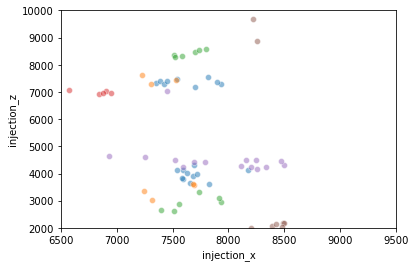

In [247]:

sns.scatterplot(visam.injection_x,visam.injection_z,alpha=0.5) #blue
sns.scatterplot(visa.injection_x,visa.injection_z,alpha=0.5) #orange
sns.scatterplot(visrl.injection_x,visrl.injection_z,alpha=0.5) #green
sns.scatterplot(s1.injection_x,s1.injection_z,alpha=0.5) #red
sns.scatterplot(rsc.injection_x,rsc.injection_z,alpha=0.5) #purple                          
sns.scatterplot(visal.injection_x,visal.injection_z,alpha=0.5) #purple                          


plt.xlim([6500,9500])
plt.ylim([2000,10000])

In [287]:
visa

,gender,injection_structures,injection_volume,injection_x,injection_y,injection_z,product_id,specimen_name,strain,structure_abbrev,structure_id,structure_name,transgenic_line,transgenic_line_id,id,primary_injection_structure
id,,,,,,,,,,,,,,,,
157769139,M,"[394, 312782546]",0.057250,7530,1240,7440,5,Syt6-Cre-617,C57BL/6J,VISa,312782546,Anterior area,Syt6-Cre_KI148,177839216.0,157769139,394
651702588,M,"[329, 361, 417, 312782546]",0.095199,7320,1290,3040,36,Tlx3-Cre_PL56-356308.0,None,VISa,312782546,Anterior area,Tlx3-Cre_PL56,265180449.0,651702588,329
656959718,M,"[329, 361, 417, 312782546]",0.130412,7240,1020,3370,36,Rbp4-Cre_KL100-360339,None,VISa,312782546,Anterior area,Rbp4-Cre_KL100,177838435.0,656959718,329
535696750,M,"[394, 533, 312782546]",0.000497,7690,1050,3570,36,A930038C07Rik-Tg1-Cre-255585,C57BL/6J,VISa,312782546,Anterior area,A930038C07Rik-Tg1-Cre,177838542.0,535696750,394
267761438,M,"[394, 312782546]",0.055607,7310,1050,7300,5,Efr3a-Cre_NO108-33,FVB.CD1(ICR),VISa,312782546,Anterior area,Efr3a-Cre_NO108,182761781.0,267761438,394
478782005,M,[312782546],0.015373,7230,560,7640,5,Sepw1-Cre_NP39-184055,None,VISa,312782546,Anterior area,Sepw1-Cre_NP39,301613169.0,478782005,312782546
597007143,M,"[385, 394, 533, 894, 312782546]",0.353367,7680,730,3630,36,Rbp4-Cre_KL100-319618,None,VISa,312782546,Anterior area,Rbp4-Cre_KL100,177838435.0,597007143,385


In [125]:
s1

,gender,injection_structures,injection_volume,injection_x,injection_y,injection_z,product_id,specimen_name,strain,structure_abbrev,structure_id,structure_name,transgenic_line,transgenic_line_id,id,primary_injection_structure
id,,,,,,,,,,,,,,,,
292124765,M,"[337, 361, 894, 312782546]",0.130520,6840,1060,6920,5,Chrna2-Cre_OE25-3901,FVB.CD1(ICR),SSp-tr,361,"Primary somatosensory area, trunk",Chrna2-Cre_OE25,182693192.0,292124765,337
298404154,M,"[337, 361, 312782546]",0.167253,6900,1100,7020,5,Gpr26-Cre_KO250-123676,None,SSp-tr,361,"Primary somatosensory area, trunk",Gpr26-Cre_KO250,177839285.0,298404154,337
100141495,M,"[337, 361]",0.130781,6420,1220,7190,5,378-696,C57BL/6J,SSp-tr,361,"Primary somatosensory area, trunk",None,NaN,100141495,337
126852363,M,"[337, 361, 382, 894, 985, 312782546]",0.413807,6880,1110,6950,5,378-1342,C57BL/6J,SSp-tr,361,"Primary somatosensory area, trunk",None,NaN,126852363,337
298182842,M,"[337, 361, 312782546]",0.078410,6570,1120,7090,5,Tlx3-Cre_LURC-130341,None,SSp-tr,361,"Primary somatosensory area, trunk",Tlx3-Cre_PL56,265180449.0,298182842,337
304641170,M,"[337, 361, 894, 312782546]",0.169124,6950,1260,6960,5,Ntsr1-Cre_GN220-141917,C57BL/6J,SSp-tr,361,"Primary somatosensory area, trunk",Ntsr1-Cre_GN220,177837713.0,304641170,337


In [25]:
pd, pd_info = mcc.get_projection_density(exp_id)

2020-11-29 10:55:21,949 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/560724955?image=projection_density&resolution=25


In [26]:
# injection density: number of projecting pixels in injection site / voxel volume
ind, ind_info = mcc.get_injection_density(exp_id)

# injection fraction: number of pixels in injection site / voxel volume
inf, inf_info = mcc.get_injection_fraction(exp_id)


2020-11-29 10:55:28,057 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/560724955?image=injection_density&resolution=25
2020-11-29 10:55:31,181 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/560724955?image=injection_fraction&resolution=25


In [27]:
dm, dm_info = mcc.get_data_mask(exp_id)

2020-11-29 10:55:33,998 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/560724955?image=data_mask&resolution=25


In [28]:
template, template_info = mcc.get_template_volume()
annot, annot_info = mcc.get_annotation_volume()

print(pd_info)
print(pd.shape, template.shape, annot.shape)

OrderedDict([('type', 'double'), ('dimension', 3), ('space', 'left-posterior-superior'), ('sizes', array([528, 320, 456])), ('space directions', array([[25.,  0.,  0.],
       [ 0., 25.,  0.],
       [ 0.,  0., 25.]])), ('kinds', ['domain', 'domain', 'domain']), ('endian', 'little'), ('encoding', 'gzip'), ('space origin', array([0., 0., 0.]))])
(528, 320, 456) (528, 320, 456) (528, 320, 456)


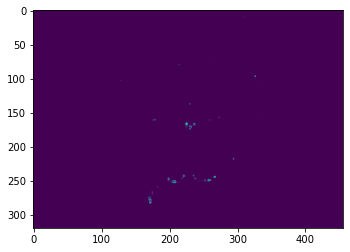

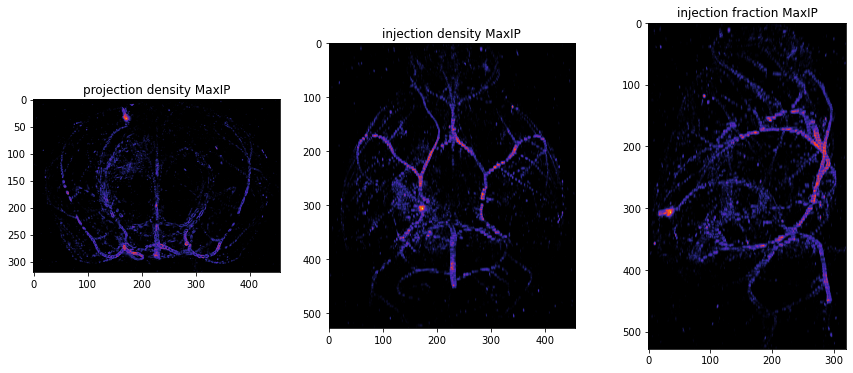

In [34]:

pd_mip = pd.max(axis=0)
ind_mip = pd.max(axis=1)
inf_mip=pd.max(axis=2)
#ind_mip = ind.max(axis=1)
#inf_mip = inf.max(axis=1)

# show that slice of all volumes side-by-side
f, pr_axes = plt.subplots(1, 3, figsize=(15, 6))

pr_axes[0].imshow(pd_mip, cmap='CMRmap', aspect='equal')
pr_axes[0].set_title("projection density MaxIP")

pr_axes[1].imshow(ind_mip, cmap='CMRmap', aspect='equal')
pr_axes[1].set_title("injection density MaxIP")

pr_axes[2].imshow(inf_mip, cmap='CMRmap', aspect='equal')
pr_axes[2].set_title("injection fraction MaxIP")

plt.show()

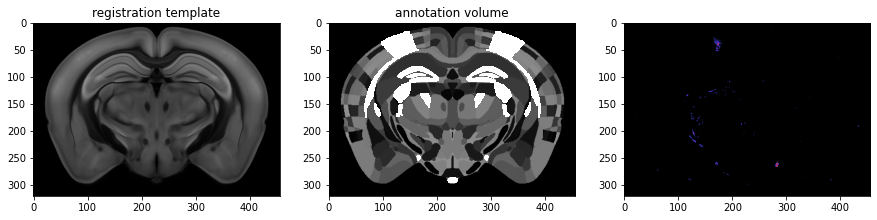

In [121]:
# Look at a slice from the average template and annotation volumes

# pick a slice to show
slice_idx = 300

f, ccf_axes = plt.subplots(1, 3, figsize=(15, 6))

ccf_axes[0].imshow(template[slice_idx,:,:], cmap='gray', aspect='equal', vmin=template.min(), vmax=template.max())
ccf_axes[0].set_title("registration template")

ccf_axes[1].imshow(annot[slice_idx,:,:], cmap='gray', aspect='equal', vmin=0, vmax=2000)
ccf_axes[1].set_title("annotation volume")

ccf_axes[2].imshow(pd[slice_idx,:,:],cmap='CMRmap',aspect='equal')

plt.show()

(528, 320, 456)

In [36]:
structure_tree = mcc.get_structure_tree()

In [186]:

exp_ids = [ e for e in visal.id ]

pm = mcc.get_projection_matrix(experiment_ids = exp_ids, 
                               hemisphere_ids= [2], # right hemisphere, ipsilateral
                               parameter = 'projection_density')


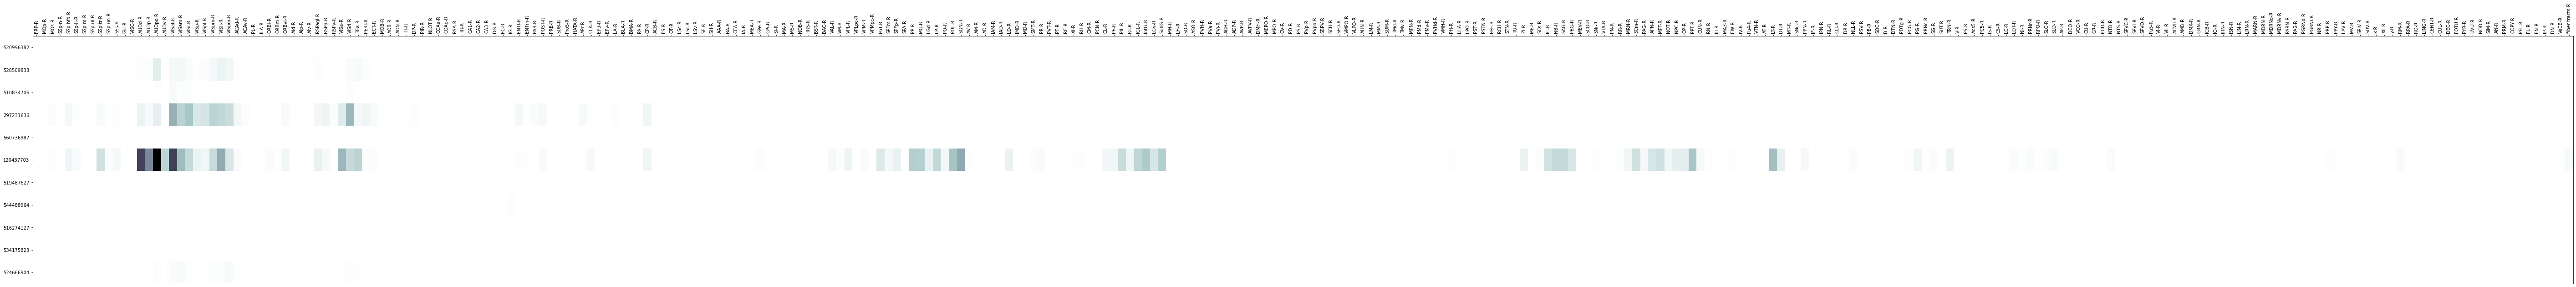

In [188]:

row_labels = pm['rows'] # these are just experiment ids
column_labels = [ c['label'] for c in pm['columns'] ] 
matrix = pm['matrix']

fig, ax = plt.subplots(figsize=(100,10))
heatmap = ax.pcolor(matrix, cmap=plt.cm.bone_r)

# put the major ticks at the middle of each cell
ax.set_xticks(np.arange(matrix.shape[1])+0.5, minor=False)
ax.set_yticks(np.arange(matrix.shape[0])+0.5, minor=False)

ax.set_xlim([0, matrix.shape[1]])
ax.set_ylim([0, matrix.shape[0]])          

# want a more natural, table-like display
ax.invert_yaxis()
ax.xaxis.tick_top()

ax.set_xticklabels(column_labels, minor=False,rotation=90)
ax.set_yticklabels(row_labels, minor=False)
plt.show()

In [310]:

exp_ids = [ e for e in yfdf.id ]

pm = mcc.get_projection_matrix(experiment_ids = exp_ids, 
                               hemisphere_ids= [2], # right hemisphere, ipsilateral
                               parameter = 'projection_density')


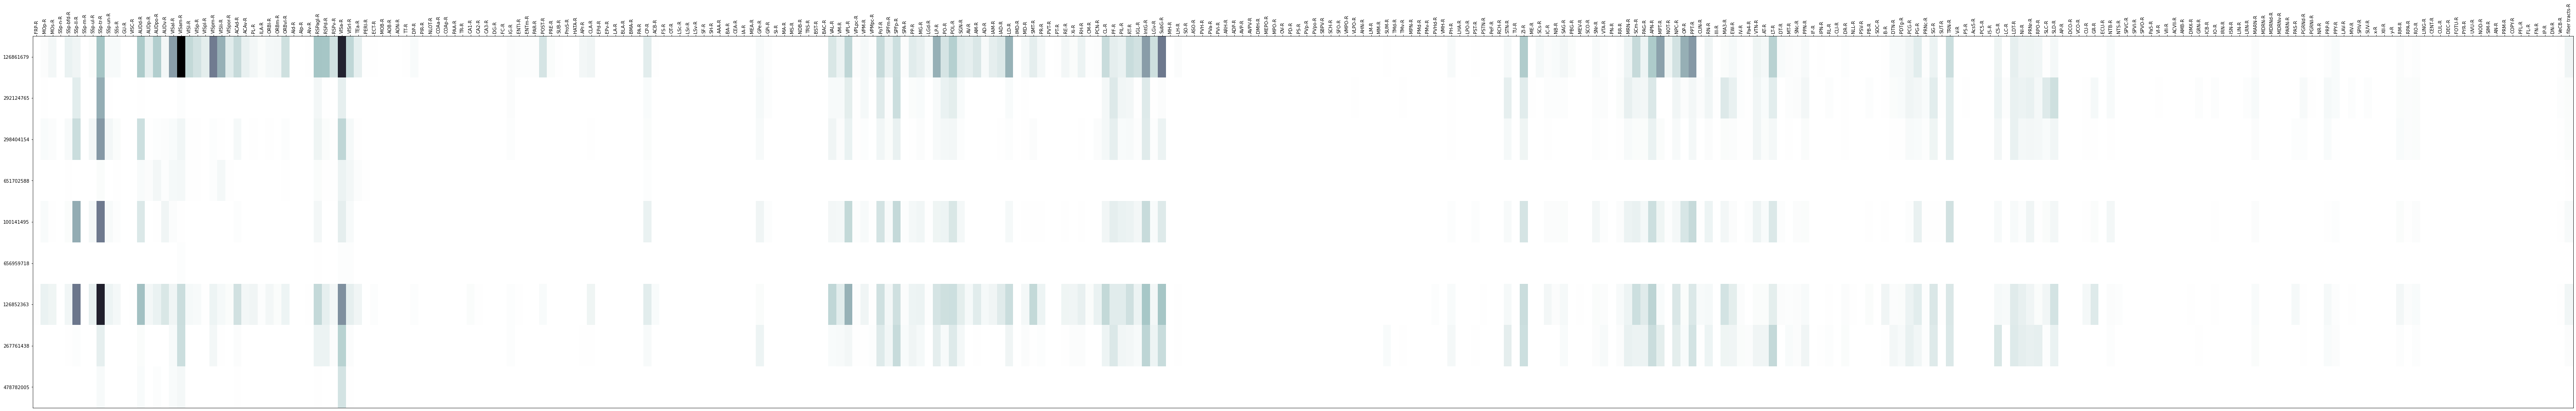

In [311]:

row_labels = pm['rows'] # these are just experiment ids
column_labels = [ c['label'] for c in pm['columns'] ] 
matrix = pm['matrix']

fig, ax = plt.subplots(figsize=(100,15))
heatmap = ax.pcolor(matrix, cmap=plt.cm.bone_r)

# put the major ticks at the middle of each cell
ax.set_xticks(np.arange(matrix.shape[1])+0.5, minor=False)
ax.set_yticks(np.arange(matrix.shape[0])+0.5, minor=False)

ax.set_xlim([0, matrix.shape[1]])
ax.set_ylim([0, matrix.shape[0]])          

# want a more natural, table-like display
ax.invert_yaxis()
ax.xaxis.tick_top()

ax.set_xticklabels(column_labels, minor=False,rotation=90)
ax.set_yticklabels(row_labels, minor=False)
plt.show()

In [312]:

exp_ids = [ e for e in gfdf.id ]

pm = mcc.get_projection_matrix(experiment_ids = exp_ids, 
                               hemisphere_ids= [2], # right hemisphere, ipsilateral
                               parameter = 'projection_density')


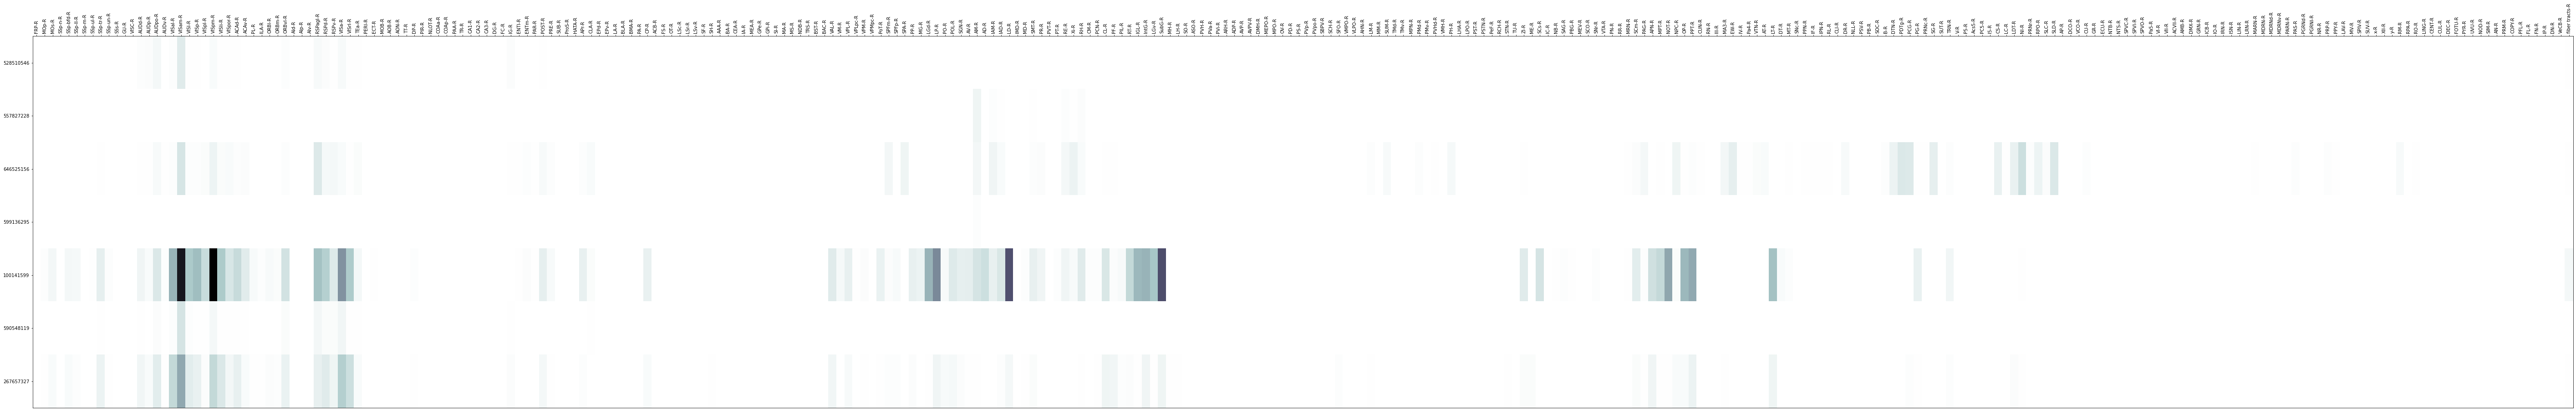

In [313]:

row_labels = pm['rows'] # these are just experiment ids
column_labels = [ c['label'] for c in pm['columns'] ] 
matrix = pm['matrix']

fig, ax = plt.subplots(figsize=(100,15))
heatmap = ax.pcolor(matrix, cmap=plt.cm.bone_r)

# put the major ticks at the middle of each cell
ax.set_xticks(np.arange(matrix.shape[1])+0.5, minor=False)
ax.set_yticks(np.arange(matrix.shape[0])+0.5, minor=False)

ax.set_xlim([0, matrix.shape[1]])
ax.set_ylim([0, matrix.shape[0]])          

# want a more natural, table-like display
ax.invert_yaxis()
ax.xaxis.tick_top()

ax.set_xticklabels(column_labels, minor=False,rotation=90)
ax.set_yticklabels(row_labels, minor=False)
plt.show()

In [192]:

exp_ids = [ e for e in s1.id ]
exp_ids
pm = mcc.get_projection_matrix(experiment_ids = exp_ids, 
                               hemisphere_ids= [2], # right hemisphere, ipsilateral
                               parameter = 'projection_density')


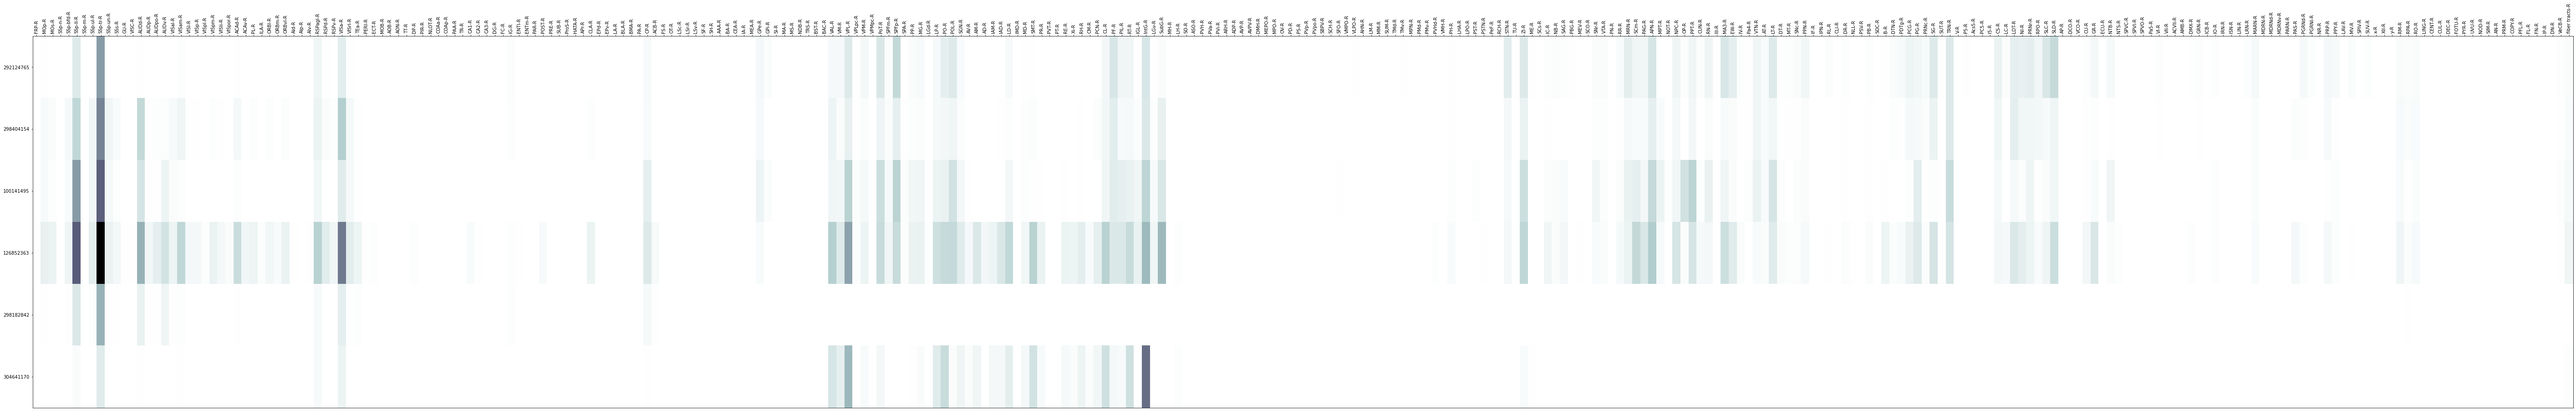

In [193]:

row_labels = pm['rows'] # these are just experiment ids
column_labels = [ c['label'] for c in pm['columns'] ] 
matrix = pm['matrix']

fig, ax = plt.subplots(figsize=(100,15))
heatmap = ax.pcolor(matrix, cmap=plt.cm.bone_r)

# put the major ticks at the middle of each cell
ax.set_xticks(np.arange(matrix.shape[1])+0.5, minor=False)
ax.set_yticks(np.arange(matrix.shape[0])+0.5, minor=False)

ax.set_xlim([0, matrix.shape[1]])
ax.set_ylim([0, matrix.shape[0]])          

# want a more natural, table-like display
ax.invert_yaxis()
ax.xaxis.tick_top()

ax.set_xticklabels(column_labels, minor=False,rotation=90)
ax.set_yticklabels(row_labels, minor=False)
plt.show()

In [194]:

exp_ids = [ e for e in rsc.id ]

pm = mcc.get_projection_matrix(experiment_ids = exp_ids, 
                               hemisphere_ids= [2], # right hemisphere, ipsilateral
                               parameter = 'projection_density')


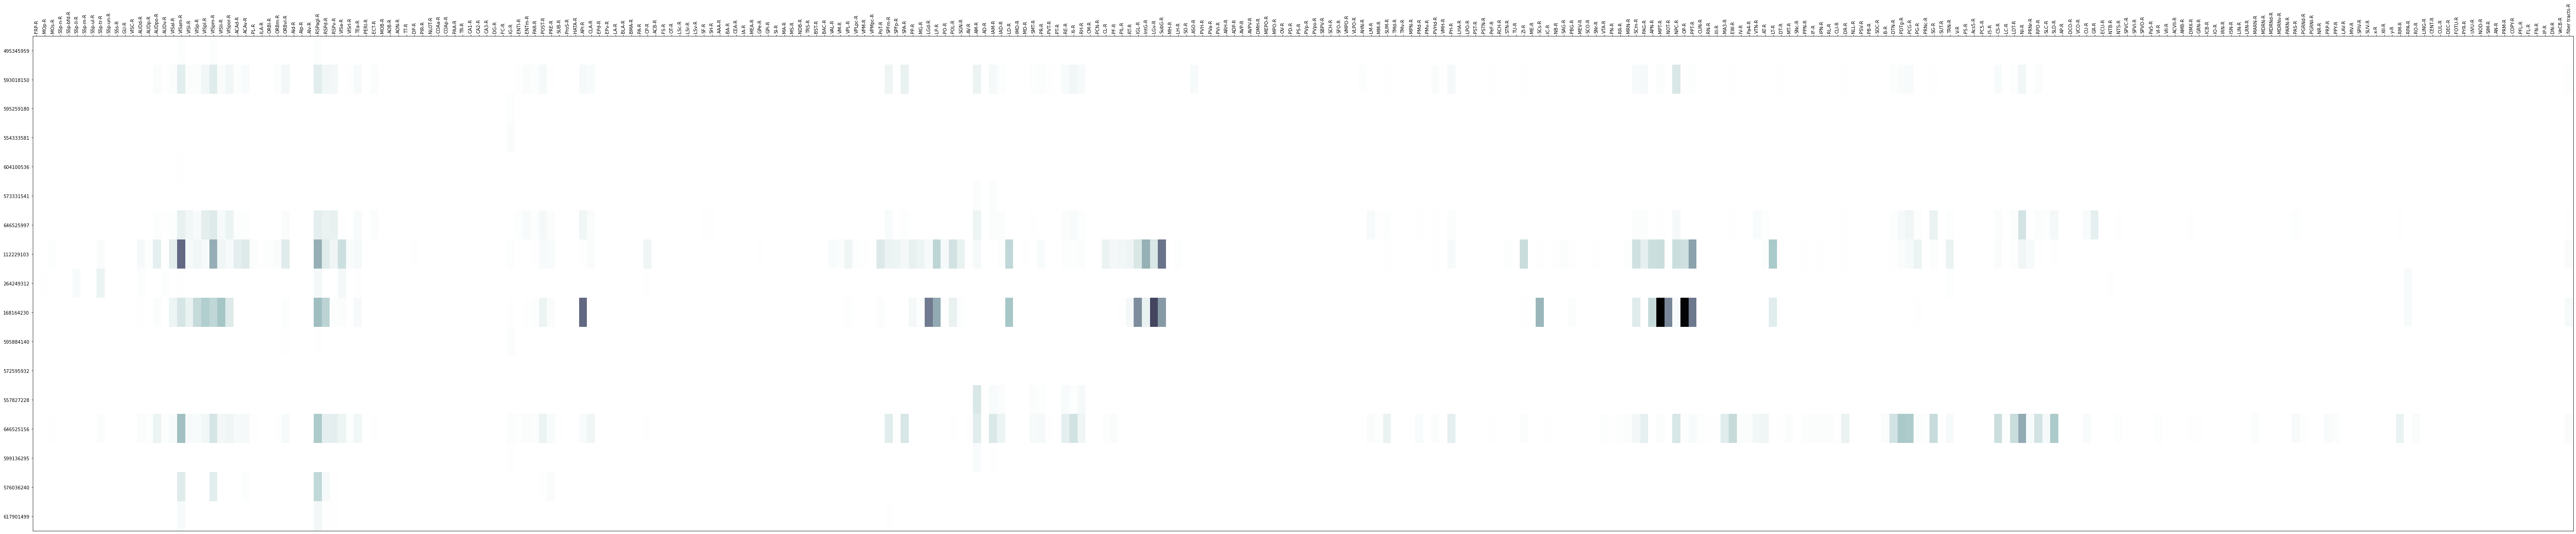

In [195]:

row_labels = pm['rows'] # these are just experiment ids
column_labels = [ c['label'] for c in pm['columns'] ] 
matrix = pm['matrix']

fig, ax = plt.subplots(figsize=(100,20))
heatmap = ax.pcolor(matrix, cmap=plt.cm.bone_r)

# put the major ticks at the middle of each cell
ax.set_xticks(np.arange(matrix.shape[1])+0.5, minor=False)
ax.set_yticks(np.arange(matrix.shape[0])+0.5, minor=False)

ax.set_xlim([0, matrix.shape[1]])
ax.set_ylim([0, matrix.shape[0]])          

# want a more natural, table-like display
ax.invert_yaxis()
ax.xaxis.tick_top()

ax.set_xticklabels(column_labels, minor=False,rotation=90)
ax.set_yticklabels(row_labels, minor=False)
plt.show()

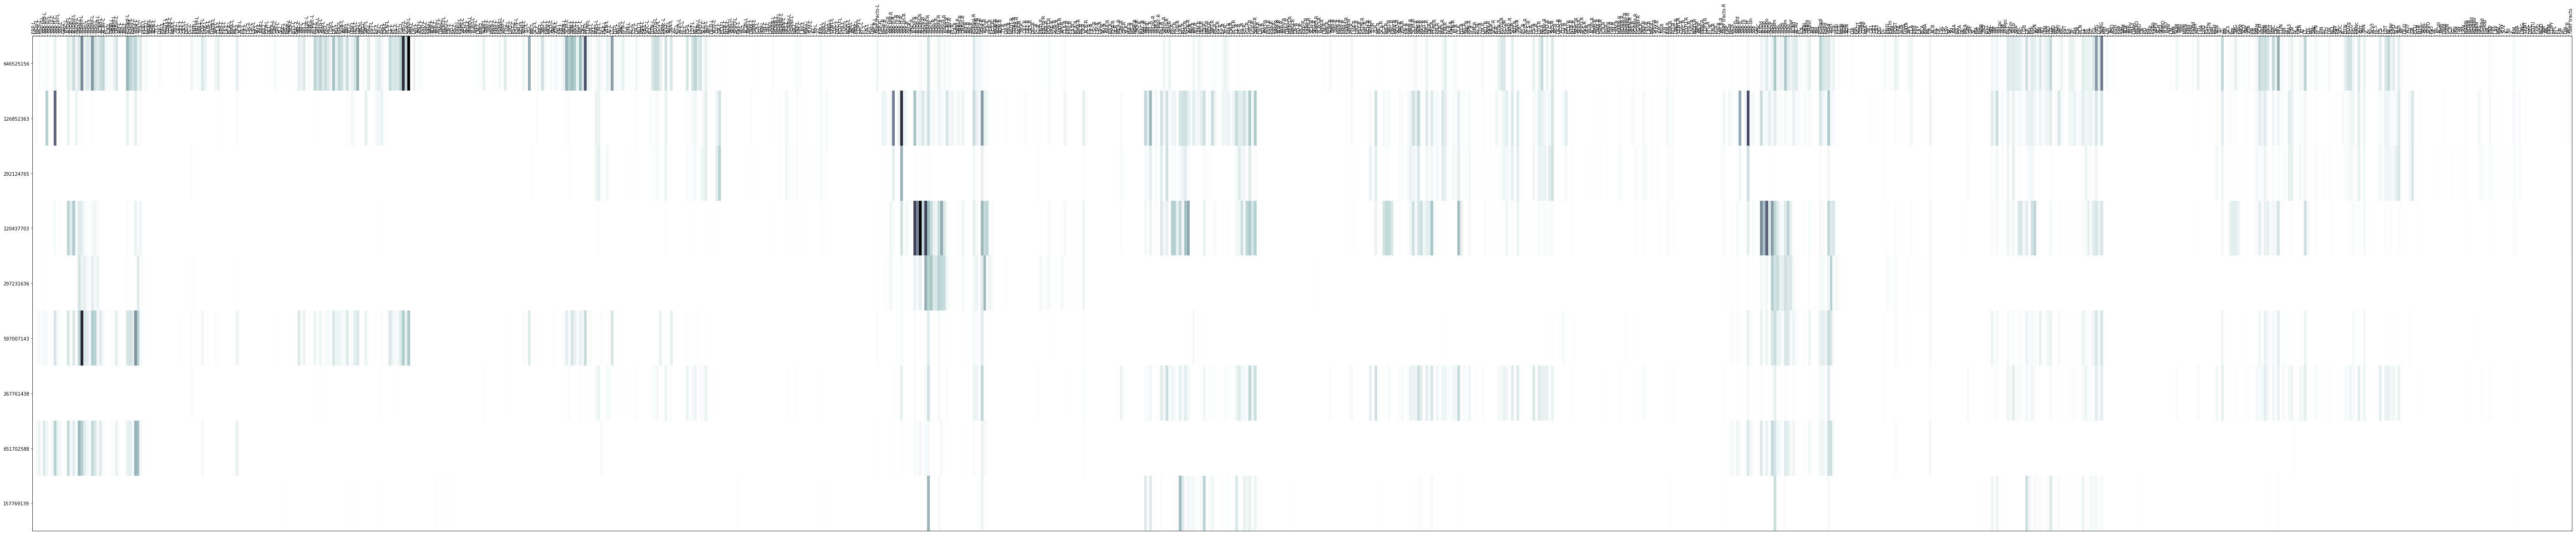

In [62]:

exp_ids = [646525156,126852363,292124765,120437703,297231636,597007143,267761438,651702588,157769139]

pm = mcc.get_projection_matrix(experiment_ids = exp_ids, 
                               parameter = 'projection_density')

row_labels = pm['rows'] # these are just experiment ids
column_labels = [ c['label'] for c in pm['columns'] ] 
matrix = pm['matrix']

fig, ax = plt.subplots(figsize=(100,20))
heatmap = ax.pcolor(matrix, cmap=plt.cm.bone_r)

# put the major ticks at the middle of each cell
ax.set_xticks(np.arange(matrix.shape[1])+0.5, minor=False)
ax.set_yticks(np.arange(matrix.shape[0])+0.5, minor=False)

ax.set_xlim([0, matrix.shape[1]])
ax.set_ylim([0, matrix.shape[0]])          

# want a more natural, table-like display
ax.invert_yaxis()
ax.xaxis.tick_top()

ax.set_xticklabels(column_labels, minor=False,rotation=90)
ax.set_yticklabels(row_labels, minor=False)
plt.show()

In [225]:
pm

{'matrix': array([[3.02332755e-05, 2.88283968e-04, 1.24606418e-03, ...,
         0.00000000e+00, 4.29105057e-05, 5.05556026e-03],
        [4.29207210e-03, 3.97916598e-02, 3.13226497e-02, ...,
         7.81345880e-05, 3.52467736e-03, 2.61334851e-02],
        [6.88731776e-04, 4.07654600e-03, 1.64935174e-03, ...,
         8.92751341e-05, 5.88317262e-03, 1.07651576e-02],
        ...,
        [6.66728599e-06, 1.58723557e-03, 1.97040444e-03, ...,
         0.00000000e+00, 7.27663399e-04, 9.13818646e-03],
        [1.07866343e-05, 8.90913848e-04, 1.99114050e-03, ...,
         0.00000000e+00, 0.00000000e+00, 2.80631357e-03],
        [1.06697989e-04, 3.53489597e-04, 1.22038143e-04, ...,
         0.00000000e+00, 0.00000000e+00, 4.29845089e-03]]),
 'rows': [646525156,
  126852363,
  292124765,
  120437703,
  297231636,
  597007143,
  267761438,
  651702588,
  157769139],
 'columns': [{'hemisphere_id': 2, 'structure_id': 184, 'label': 'FRP-R'},
  {'hemisphere_id': 2, 'structure_id': 985, 'label': 'M

In [242]:
all_experiments[all_experiments.structure_id== 507]
#temporal association #ectorhinal 

,gender,injection_structures,injection_volume,injection_x,injection_y,injection_z,product_id,specimen_name,strain,structure_abbrev,structure_id,structure_name,transgenic_line,transgenic_line_id,id,primary_injection_structure
id,,,,,,,,,,,,,,,,
175731154,F,"[151, 159, 507]",0.042027,2240,3670,6510,5,Cdhr1-Cre-130,C57BL/6J,MOB,507,Main olfactory bulb,Cdhr1-Cre_KG66,177838331.0,175731154,151
304947087,M,[507],0.036388,1530,4670,6130,5,Gpr26-Cre_KO250-135015,None,MOB,507,Main olfactory bulb,Gpr26-Cre_KO250,177839285.0,304947087,507
166154193,M,[507],0.246995,850,5900,6430,5,Slc6a3-Cre-4501,C57BL/6J,MOB,507,Main olfactory bulb,Slc6a3-Cre,177838074.0,166154193,507
300644693,M,[507],0.002783,1020,5210,6520,5,Slc17a6-IRES-Cre-126489,B6.129,MOB,507,Main olfactory bulb,Slc17a6-IRES-Cre,177838048.0,300644693,507
175728165,M,[507],0.068451,2540,5240,5850,5,Cdhr1-Cre-124,None,MOB,507,Main olfactory bulb,Cdhr1-Cre_KG66,177838331.0,175728165,507
146859480,M,[507],0.277699,590,5750,6500,5,Cdhr1-Cre-60,None,MOB,507,Main olfactory bulb,Cdhr1-Cre_KG66,177838331.0,146859480,507
100141222,M,"[159, 507]",0.249725,1640,5300,6930,5,378-638,C57BL/6J,MOB,507,Main olfactory bulb,None,NaN,100141222,159
146921849,F,[507],0.084538,580,3320,7150,5,Cdhr1-Cre-63,None,MOB,507,Main olfactory bulb,Cdhr1-Cre_KG66,177838331.0,146921849,507
166156241,M,"[151, 507]",0.028949,960,3490,6450,5,Slc6a3-Cre-4502,C57BL/6J,MOB,507,Main olfactory bulb,Slc6a3-Cre,177838074.0,166156241,151


In [295]:
from allensdk.core.reference_space_cache import ReferenceSpaceCache

In [301]:
resolution = 25
reference_space_key='annotation/ccf_2017'


TypeError: __init__() takes 3 positional arguments but 5 were given

In [297]:
rspc

allensdk.core.reference_space_cache.ReferenceSpaceCache

In [299]:
tree = rspc.get_structure_tree(structure_graph_id=1)

TypeError: get_structure_tree() missing 1 required positional argument: 'self'

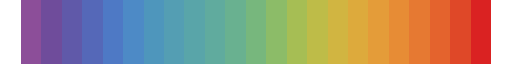

In [61]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np


from matplotlib.colors import ListedColormap

colors = [[255,255,255],[140,78,153],[111,76,155],[96,89,169],[85,104,184],[78,121,197],[77,138,198],[78,150,188],[84,158,179],[89,165,169],[96,171,158],[105,177,144],[119,183,125],[140,188,104],[166,190,84],[190,188,72],[209,181,65],[221,170,60],[228,156,57],[231,140,53],[230,121,50],[228,99,45],[223,72,40],[218,34,34],[255,255,255]]
cell_rainbow = ListedColormap(np.divide(colors,255), name='cell_rainbow', N=None)
cell_rainbow